In [22]:
import tensorflow as tf

In [23]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [24]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

print(type(train_images))
train_images=np.expand_dims(train_images, axis=-1)
train_images=train_images.astype('float32')

train_images=(train_images-127.5)/127.5



<class 'numpy.ndarray'>


In [25]:
BATCH_SIZE=256
BUFFER_SIZE=train_images.shape[0]

In [26]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

In [27]:
def generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

    return model

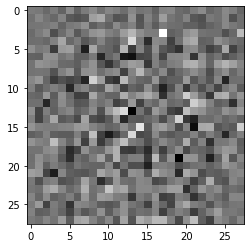

In [28]:
gen=generator_model()
noise=tf.random.normal([1,100])
generated_im=gen(noise,training=False)

plt.imshow(generated_im[0,:,:,0],cmap="gray")

In [29]:
def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [30]:
disc=discriminator_model()
decision=disc(generated_im)
print(decision)

tf.Tensor([[0.00074784]], shape=(1, 1), dtype=float32)


In [31]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

In [33]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [34]:
gen_optimizer=tf.keras.optimizers.Adam(1e-4)
disc_optimizer=tf.keras.optimizers.Adam(1e-4)

In [35]:
checkpoint_dir='./training_checkpoits'
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=gen_optimizer,discriminator_optimizer=disc_optimizer,generator=gen,discriminator=disc)

In [36]:
EPOCHS=50
noise_dim=100
num_examples_to_generate=16

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [37]:
@tf.function
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE,noise_dim])

    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        gen_images=gen(noise,training=True)

        real_output=disc(images,training=True)
        fake_output=disc(gen_images,training=True)

        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
    grads_gen=gen_tape.gradient(gen_loss,gen.trainable_variables)
    grads_disc=disc_tape.gradient(disc_loss,disc.trainable_variables)

    gen_optimizer.apply_gradients(zip(grads_gen,gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(grads_disc,disc.trainable_variables))

In [38]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()

        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(gen,epoch+1,seed)

        if (epoch+1)%15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {} sec".format(epoch+1,time.time()-start))
    
    display.clear_output(wait=True)
    generate_and_save_images(gen,epochs,seed)

In [39]:
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=False)

    fig=plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*27.5+127.5,cmap="gray")
        plt.axis("off")

    plt.savefig('epoch_images\\image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

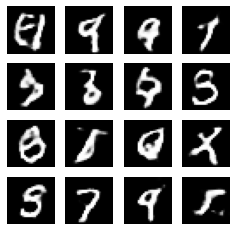

In [40]:
train(train_dataset,EPOCHS)

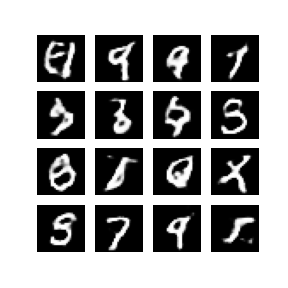

In [42]:
def display_image(epoch_no):
  return PIL.Image.open('epoch_images\\image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)